# Visualizing CNN features with heat maps

In this notebook, I use Keras to visualize image features in a convolutional neural network (CNN). This can be a useful tool to debug your models. If you are new to neural networks, this might also give you a better high-level understanding of how image classification works.

This is done in about 70 lines of code, including explanatory comments.

Since we only do forward-passes, all code should run fine on CPUs (assuming your computer isn't too old).

All images were fetched from https://pixabay.com/.

In [168]:
from keras.models import Model
from keras.layers import Conv2D, Input
import numpy as np
import keras.backend as K
from PIL import Image
from IPython.display import display

# prevent OOM issues
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)


In [169]:
# returns the i:th layer's activations of model
def get_activations(i, model):
    return K.function([model.layers[0].input], [model.layers[i].output])

In [170]:
# so we can disable all prints at once
# but still get detailed info if we want to debug
def dprint(*args, debug):
    if debug:
        print(args)

In [171]:
# shows the activation heat map of the input image
def show_heatmap(inp_img, model, index, alpha=0.7, debug=False):
    # convert the image into a numpy array
    inp_arr = np.array(inp_img).reshape(1, inp_img.width, inp_img.height, 3)
    # predict the class of the image and print the top 3 predictions
    pred = model.predict([inp_arr])
    print([(label, conf) for _, label, conf in decode_predictions(pred)[0][:3]])
    
    # fetch the activations of layer index
    out = get_activations(index, model)([inp_arr])[0][0]
    dprint("activations", out.shape, debug=debug)
    
    # for each region of the activation map, calculate the average filter activations
    out_avg = np.mean(out, -1)
    dprint("post avg", out_avg.shape, debug=debug)

    # repeat the array into 3 dimensions
    out_avg = np.repeat(out_avg[:, :, np.newaxis], 3, axis=2)
    dprint("post repeat", out_avg.shape, debug=debug)
    
    # normalize the values into the range [0,1]
    dprint("pre normalize", np.amin(out_avg), np.amax(out_avg), debug=debug)
    out_avg /= np.amax(out_avg)
    dprint("post normalize", np.amin(out_avg), np.amax(out_avg), debug=debug)
    
    # transform the values into RGB range with a pink tint
    out_avg *= (255,0,128)
    dprint("post denormalize", np.amin(out_avg), np.amax(out_avg), debug=debug)

    # convert the average activations into an image and resize it to the input shape
    heatmap = Image.fromarray(np.uint8(out_avg))
    heatmap = heatmap.resize((inp_img.width, inp_img.height), Image.BICUBIC)

    # superimpose the heatmap on top of the input image
    input_heatmap = Image.blend(inp_img, heatmap, alpha)
    
    # show the result
    display(input_heatmap)

In [172]:
# use VGG19 with pretrained ImageNet weights
from keras.applications.vgg19 import VGG19, decode_predictions
vgg = VGG19()

In [173]:
# Take activations from the last MaxPool layer
activations_index = -5
assert "block5_pool" == vgg.layers[activations_index].name
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [174]:
from glob import glob

def load_images(path, img_w=224, img_h=224):
    paths = glob(path)
    for p in paths:
        inp_img = Image.open(p)
        yield inp_img.resize((img_w, img_h))

[('missile', 0.58071667), ('space_shuttle', 0.23233528), ('projectile', 0.13431515)]


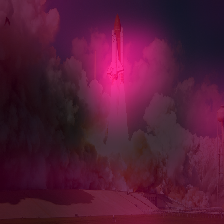

[('volcano', 0.92195445), ('conch', 0.052368388), ('alp', 0.010560113)]


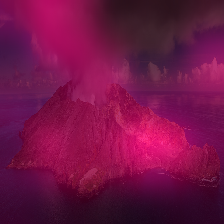

[('wood_rabbit', 0.5641848), ('hare', 0.37138048), ('coyote', 0.018360214)]


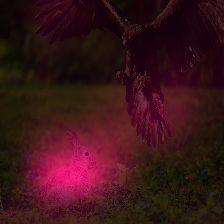

[('dalmatian', 0.96605843), ('whippet', 0.015291788), ('German_short-haired_pointer', 0.006996258)]


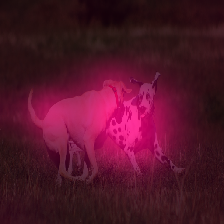

[('military_uniform', 0.31457028), ('rifle', 0.15194458), ('assault_rifle', 0.087423146)]


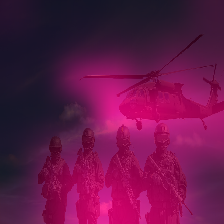

[('balloon', 0.99978393), ('parachute', 0.00020682462), ('maraca', 5.5320324e-06)]


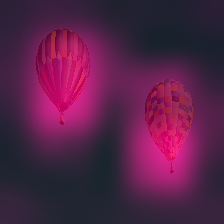

[('golfcart', 0.5762165), ('racer', 0.38245296), ('sports_car', 0.011333555)]


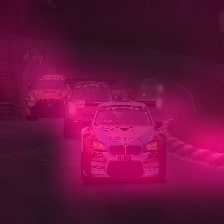

[('African_elephant', 0.93167067), ('tusker', 0.042763557), ('Indian_elephant', 0.022968665)]


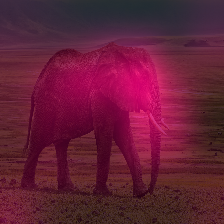

[('library', 0.9831129), ('bookcase', 0.011910071), ('bookshop', 0.0047296844)]


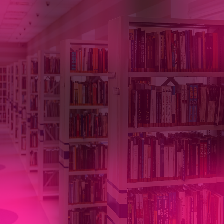

[('necklace', 0.6132329), ('chain', 0.09728911), ('thimble', 0.053564686)]


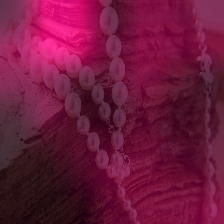

[('schooner', 0.34319058), ('yawl', 0.26655188), ('missile', 0.07017782)]


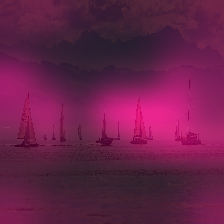

In [175]:
for img in load_images('img/*jpg'):
    show_heatmap(img, vgg, index=activations_index, alpha=0.8, debug=False)

# Why does this work?

If you have read and understood what the code is doing, you know that we are producing the heat map by averaging the kernel activations of the last MaxPool layer. The heat map thus shows which regions of this average activation map that have high values.

The network's output layer is a one dimensional array of size C (number of classes) wrapped in a softmax activation function. The network is trained to produce high values in output neuron *i* for images belonging to class *i*. For example, given 3 classes the network is trained for class 0 as input to output a vector close to [1 0 0], for class 1 as input a vector close to [0 1 0], and for class 2 as input a vector close to [0 0 1]. This is also the case for VGG19, but with 1000 classes instead of 3.


Since matrix multiplications are weighted sums, we see that a high value of an output neuron corresponds to the inputs of that neuron also having high values (assuming non-negative weights). Therefore, regions in the activation map with high values will have a large effect on which neuron in the output layer gets the largest value. So, in short, high values in the activation map tell us that those values are responsible for the classification result.

Now, one question remains. Why does the activation map spatially correspond to the input image?

In the code above, I have written the following

```
    heatmap = heatmap.resize((inp_img.width, inp_img.height), Image.BICUBIC)
    input_heatmap = Image.blend(inp_img, heatmap, alpha)
```

which takes the heat map image of shape (7, 7, 3) and rescales it to the input dimensions (224, 224, 3). If you give me the benefit of the doubt and assume that it is correct to do so, it means that each grid in the 7x7 heat map represents the high level features of a corresponding 32x32 pixel region in the input image.

Why is that? Let's make a toy example and play around a little.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 111, 111, 3)       84        
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 55, 55, 3)         84        
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 27, 27, 3)         84        
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 13, 13, 3)         84        
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 6, 6, 3)           84        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
##### Input 

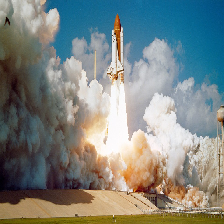

##### conv2d_151 #####
Convolution output:


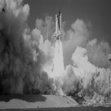

Convolution output resized to input image dimensions:


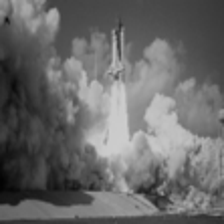

##### conv2d_152 #####
Convolution output:


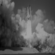

Convolution output resized to input image dimensions:


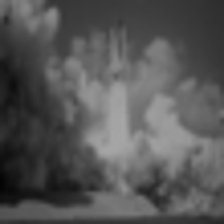

##### conv2d_153 #####
Convolution output:


Convolution output resized to input image dimensions:


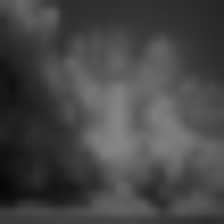

##### conv2d_154 #####
Convolution output:


Convolution output resized to input image dimensions:


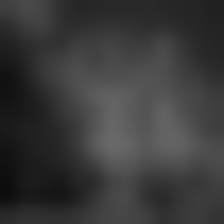

##### conv2d_155 #####
Convolution output:


Convolution output resized to input image dimensions:


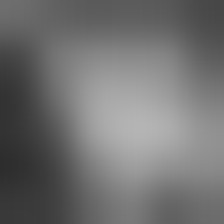

In [176]:
from keras.initializers import Constant


# Create a convolutional neural network with 4 convolutional layers
inputs = Input((img.width,img.height,3))
conv1 = Conv2D(filters=3, kernel_size=3, strides=2, kernel_initializer=Constant(0.03))(inputs)
conv2 = Conv2D(filters=3, kernel_size=3, strides=2, kernel_initializer=Constant(0.03))(conv1)
conv3 = Conv2D(filters=3, kernel_size=3, strides=2, kernel_initializer=Constant(0.03))(conv2)
conv4 = Conv2D(filters=3, kernel_size=3, strides=2, kernel_initializer=Constant(0.03))(conv3)
outputs = Conv2D(filters=3, kernel_size=3, strides=2, kernel_initializer=Constant(0.07))(conv4)


model = Model(inputs, outputs)
model.compile(loss='mse', optimizer='adam') # dummy parameters
model.summary()

img = load_images('img/*jpg').__next__()

inp_arr = np.array(img).reshape(1, img.width, img.height, 3)

print("#"*5, "Input", "#"*5)
display(img)
# Show the output at each layer
for i, _ in enumerate(model.layers[:-1], start=1):
    print("#"*5, model.layers[i].name, "#"*5)
    
    activations = get_activations(i, model)([inp_arr])[0][0]
    activations = np.uint8(activations)
    activations = Image.fromarray(activations)
    
    
    resized_activations = activations.resize((img.width, img.height), Image.BICUBIC)
    print("Convolution output:")
    display(activations)
    print("Convolution output resized to input image dimensions:")
    display(resized_activations)


See how in each step, the output size is reduced. What seems to happen is that after each convolution, the output is a resized version of the input. Of course we can see in the model summary that the output size is halved, but when looking at the output images note how the image features are retained in each step. If we resize the output into the same shape as the input image, we see that the overall image features are intact and that they do contain the same (but compressed) information in the corresponding input regions.

This method of upscaling an activation map to match the input image size is exactly how we produced our heat map before. There are only two differences. 

- First, the kernels in VGG19 were trained to extract useful information that help with classification, whereas the kernels in this example have constant values. 
- Second, in this example we used 3 kernels for each convolution layer, which means that the output channel dimension is 3 in each step. In VGG19, we used up to 512 different kernels in a single convolution layer. 

Thus, even though the last MaxPool layer in VGG19 has a low spatial resolution (7x7), it still contains huge amounts of information since it for each of those grid cells have 512 values. While we don't know what these 512 values represent exactly, we know that they represent high level features of the corresponding input region. Perhaps the presence of a fluffy ear or a smile.

We have now verified that the convolutional activation maps retain spatial information throughout the network. What is left, is understanding why that happens.

If not already familiar, you should understand (at least intuitively) how a convolution works by looking at the following GIF ([source](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)).

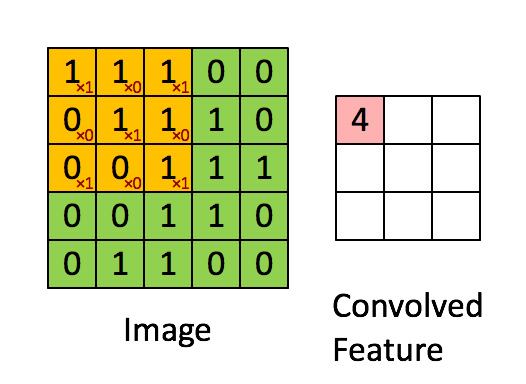

The kernel slides over the input and for each kernel position computes the sum of the elementwise multiplication of the receptive field (yellow) and the kernel weights (red). 

**Now that we see this process visually, we immediately realize why the heat map works: since each neuron in the activation map is the sum of the dot product of the receptive field and the kernel weights, each neuron in the activation map represents the important features (decided by the kernel weights) of its receptive field.**